Epoch 1/50


293/293 [==============================] - 5s 7ms/step - loss: 1.3093 - accuracy: 0.5267 - val_loss: 1.0289 - val_accuracy: 0.6034
Epoch 2/50
293/293 [==============================] - 1s 5ms/step - loss: 0.8745 - accuracy: 0.6632 - val_loss: 0.8532 - val_accuracy: 0.6516
Epoch 3/50
293/293 [==============================] - 2s 5ms/step - loss: 0.7730 - accuracy: 0.6861 - val_loss: 0.7893 - val_accuracy: 0.6762
Epoch 4/50
293/293 [==============================] - 1s 4ms/step - loss: 0.7187 - accuracy: 0.7130 - val_loss: 0.7465 - val_accuracy: 0.6946
Epoch 5/50
293/293 [==============================] - 1s 4ms/step - loss: 0.6841 - accuracy: 0.7196 - val_loss: 0.7162 - val_accuracy: 0.6993
Epoch 6/50
293/293 [==============================] - 1s 4ms/step - loss: 0.6616 - accuracy: 0.7240 - val_loss: 0.6978 - val_accuracy: 0.7033
Epoch 7/50
293/293 [==============================] - 1s 3ms/step - loss: 0.6446 - accuracy: 0.7290 - val_loss: 0.6884 - val_accuracy: 0.7223
Epoc

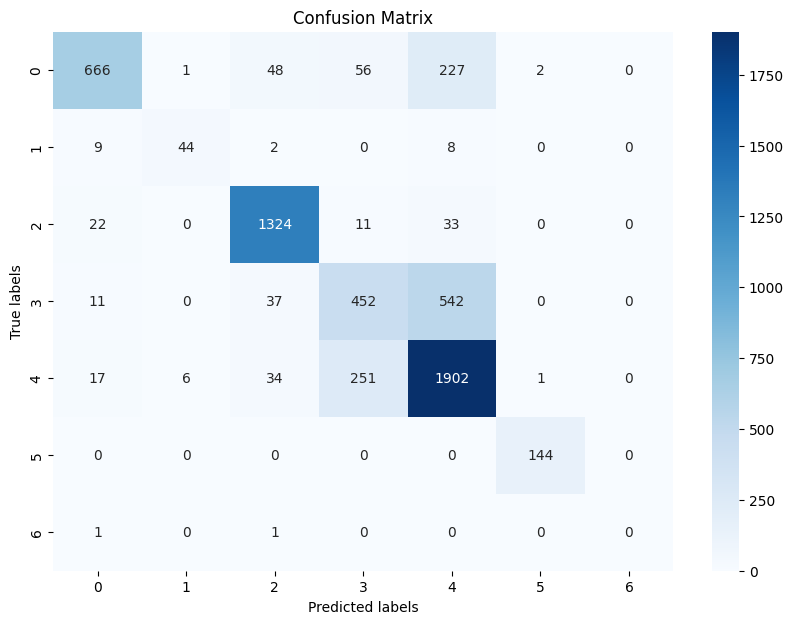

Model and preprocessors saved successfully.


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pickle

# Load the data
file_paths = [
    'Multiclass Labeled Data/bag_toss_labeled_1.csv',
    'Multiclass Labeled Data/sitting_up_down_labeled_2.csv',
    'Multiclass Labeled Data/stairs_labeled_4.csv',
    'Multiclass Labeled Data/walking_labeled_3.csv',
    'Multiclass Labeled Data/standing_labeled_5.csv'
]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
combined_data = pd.concat(data_frames)

# Preprocess the data
data_for_model = combined_data.drop(columns=['timestamp'])  # Drop timestamp
X = data_for_model.drop(columns=['label'])
y = data_for_model['label'].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train_lstm, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], batch_size=64)

# Save the model and preprocessors
# model.save('lstm_model.h5') #legacy not optimal save in .keras
model.save('LSTM_multi_sinput.keras')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Predict the test set
y_pred_prob = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
print(f"F1 Score: {f1}")

# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot it
# Plotting confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Model and preprocessors saved successfully.")


In [13]:
data_for_model.head()
print(data_for_model)
print(X_train_lstm)

     acceleration_x  acceleration_y  acceleration_z  gyroscope_x  gyroscope_y  \
0            0.6799         -0.0400         -0.7637      -1.5182       1.5335   
1            0.6787         -0.0454         -0.7712      -1.3046       1.4954   
2            0.6790         -0.0391         -0.7598      -1.0529       1.3123   
3            0.6743         -0.0354         -0.7656      -1.2894       1.3962   
4            0.6711         -0.0393         -0.7603      -1.1368       1.3809   
..              ...             ...             ...          ...          ...   
815         -0.8477         -0.0168          0.0383      -0.9918       0.0000   
816         -0.8301         -0.0161          0.0508       1.1673       1.3885   
817         -0.8486         -0.0010          0.0354       1.2436       4.4785   
818         -0.8547          0.0015          0.0430      -0.0916       1.2589   
819         -0.8401         -0.0007          0.0388      -2.2049       1.5106   

     gyroscope_z  label  
0

In [16]:
print(X_train_lstm)

[[[ 0.40302177  0.42926801  0.1146559   1.26038993 -1.19940749
    1.97893577]]

 [[ 0.16889011  0.00336906  1.80690971  0.02438356 -0.09762459
    0.08637425]]

 [[ 0.141885    0.01262773 -0.11278301  2.66970918  0.32999807
    1.35133661]]

 ...

 [[ 0.59127097  0.99949333 -2.24800117  0.43942691 -1.35268786
    0.52726997]]

 [[-0.60691682  0.67489515  0.14443957 -0.727732    1.64898484
    0.13244185]]

 [[ 0.51523717 -1.81950022  0.93966348 -1.03418224  0.55923856
    0.18609977]]]


In [6]:
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('LSTM_model.keras')
# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
# Load the encoder
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)


In [29]:
import pandas as pd
data = {'acceleration_x': -0.2246, 'acceleration_y': 0.0603, 'acceleration_z': 1.0576, 'gyroscope_x': -1.5259, 'gyroscope_y': 1.5411, 'gyroscope_z': -1.3123}
df = pd.DataFrame([data])
data2 = {'acceleration_x': -1.2246, 'acceleration_y': 1.0603, 'acceleration_z': 1.0576, 'gyroscope_x': -1.5259, 'gyroscope_y': 1.5411, 'gyroscope_z': -1.3123}
new_row1 = pd.DataFrame([data2])
data3 = {'acceleration_x': -2.2246, 'acceleration_y': 1.0603, 'acceleration_z': 1.0576, 'gyroscope_x': -1.5259, 'gyroscope_y': 1.5411, 'gyroscope_z': -1.3123}
new_row2 = pd.DataFrame([data3])

df = pd.concat([df, new_row1], ignore_index=True)
df = pd.concat([df, new_row2], ignore_index=True)
print(df)



   acceleration_x  acceleration_y  acceleration_z  gyroscope_x  gyroscope_y  \
0         -0.2246          0.0603          1.0576      -1.5259       1.5411   
1         -1.2246          1.0603          1.0576      -1.5259       1.5411   
2         -2.2246          1.0603          1.0576      -1.5259       1.5411   

   gyroscope_z  
0      -1.3123  
1      -1.3123  
2      -1.3123  


In [30]:


#df = pd.DataFrame([data])
# Preprocess data
scaled_data = scaler.transform(df)
print(scaled_data)


[[ 1.39146115  0.74678602  2.88697378  0.04371266  0.01818132  0.01537615]
 [-1.23039396  6.19306414  2.88697378  0.04371266  0.01818132  0.01537615]
 [-3.85224908  6.19306414  2.88697378  0.04371266  0.01818132  0.01537615]]


In [31]:

reshaped_data = np.reshape(scaled_data, (-1, 1, 6))  # Reshape for LSTM input
print(reshaped_data)

[[[ 1.39146115  0.74678602  2.88697378  0.04371266  0.01818132
    0.01537615]]

 [[-1.23039396  6.19306414  2.88697378  0.04371266  0.01818132
    0.01537615]]

 [[-3.85224908  6.19306414  2.88697378  0.04371266  0.01818132
    0.01537615]]]


In [41]:

# Predict
prediction = model.predict(reshaped_data)
# prediction = model.predict(data)
predicted_label_index = np.argmax(prediction, axis=1)
# Decode prediction
predicted_label = encoder.inverse_transform(predicted_label_index)
print(predicted_label_index)
print(predicted_label)  # Return the label 

1/1 [==============================] - 0s 31ms/step
[2 4 4]
[2. 4. 4.]


In [39]:
print(X_train_lstm.shape[2])

6
